In [1]:
from argparse import ArgumentParser
import warnings
from typing import Callable, Union
from enum import Enum
from itertools import product
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import nn
from torch import optim
from torch_geometric.nn import GATConv, global_add_pool, GINEConv, GlobalAttention, JumpingKnowledge
from torch_geometric.nn import global_mean_pool
import torch
import torch.nn.functional as F
import torch_geometric
import torchmetrics
from torch.utils.data import Dataset
import pytorch_lightning as L
from pytorch_lightning.loggers import Logger, WandbLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import networkx as nx
import rdkit.Chem
from tqdm.contrib.concurrent import process_map
from torch_geometric import nn as geo_nn
from torch_geometric.data import Data, DataLoader
from torch.autograd import grad

# define all the necessary modulesdefaultdict

In [2]:
class GNEPropTask(Enum):
    BINARY_CLASSIFICATION = 'binary_classification'
    REGRESSION = 'regression'
    MULTI_CLASSIFICATION = 'multi_classification'

    def get_metrics(self) -> list[str]:
        if self.value in ('binary_classification', 'multi_classification'):
            return ['auc', 'ap', 'acc']
        elif self.value == 'regression':
            return ['mse', 'mae']

    def get_default_metric(self) -> str:
        if self.value in ('binary_classification', 'multi_classification'):
            return 'auc'
        elif self.value == 'regression':
            return 'mse'

    @staticmethod
    def validation_names(m) -> Union[str, list[str]]:
        if isinstance(m, str):
            return 'val/' + m
        elif isinstance(m, Sequence):
            return ['val/' + i for i in m]


class GNNMolEncoder(nn.Module):
    def __init__(self, node_dim: int, edge_dim: int, hidden_dim_graph: int, hidden_dim_ffn: int, num_mp_layers: int,
                 num_readout_layers: int,
                 out_channels: int,
                 dropout: float, aggr: str = 'mean', jk: str = 'cat'):
        super().__init__()

        # graph encoder
        self.node_encoder = nn.Linear(node_dim, hidden_dim_graph)
        self.edge_encoder = nn.Linear(edge_dim, hidden_dim_graph)

        self.convs = nn.ModuleList()
        for _ in range(num_mp_layers):
            mlp = nn.Sequential(
                nn.Linear(hidden_dim_graph, 2 * hidden_dim_graph),
                nn.BatchNorm1d(2 * hidden_dim_graph),
                nn.ReLU(inplace=True),
                nn.Linear(2 * hidden_dim_graph, hidden_dim_graph),
                nn.BatchNorm1d(hidden_dim_graph),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout)
            )
            conv = GINEConv(mlp, train_eps=True)
            self.convs.append(conv)

        self.jk_mode = jk
        if self.jk_mode == 'none':
            self.jk = None
        else:
            self.jk = JumpingKnowledge(mode=self.jk_mode, channels=hidden_dim_graph, num_layers=num_mp_layers)

        # global pooling
        self.aggr = aggr
        if aggr == 'mean':
            self.global_pool = global_mean_pool
        elif aggr == 'sum':
            self.global_pool = global_add_pool

        # classifier
        self.classifier = nn.ModuleList()

        if self.jk_mode == 'none':
            hidden_channels_mol = hidden_dim_graph
        elif self.jk_mode == 'cat':
            hidden_channels_mol = hidden_dim_graph * (num_mp_layers + 1)
        else:
            raise NotImplementedError

        for layer in range(num_readout_layers):
            input_dim = hidden_channels_mol if layer == 0 else hidden_dim_ffn
            mlp = nn.Sequential(
                nn.Linear(input_dim, hidden_dim_ffn),
                nn.BatchNorm1d(hidden_dim_ffn),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout),
            )
            self.classifier.append(mlp)

        # last layer (classifier)
        input_dim_classifier = hidden_channels_mol if num_readout_layers == 0 else hidden_dim_ffn
        self.classifier.append(nn.Linear(input_dim_classifier, out_channels), )

    def compute_message_passing(self, data: torch_geometric.data.Data) -> torch.Tensor:
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        list_graph_encodings = []

        x_encoded = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)

        if self.jk_mode != 'none':
            list_graph_encodings.append(x_encoded)
        for conv in self.convs:
            x_encoded = conv(x_encoded, edge_index, edge_attr)
            if self.jk_mode != 'none':
                list_graph_encodings.append(x_encoded)

        if self.jk_mode != 'none':
            x_encoded = self.jk(list_graph_encodings)

        out = self.global_pool(x_encoded, batch)  # [batch_size, hidden_channels]
        return out

    def compute_readout(self, graph_repr: torch.Tensor, restrict_output_layers: int = 0) -> torch.Tensor:
        out = graph_repr
        for mlp in self.classifier[:None if restrict_output_layers == 0 else restrict_output_layers]:
            out = mlp(out)
        return out

    def forward(self, data: torch_geometric.data.Data) -> torch.Tensor:
        graph_repr = self.compute_message_passing(data)
        out = self.compute_readout(graph_repr)
        return out


def predict_ensemble(list_checkpoints: list[str], data: Union[torch.utils.data.Dataset, torch.utils.data.DataLoader],
                     aggr: str = 'mean',
                     gpus: int = 1) -> tuple[np.ndarray, np.ndarray]:
    # works only for single input
    all_preds = []
    for checkpoint in list_checkpoints:
        print(f'Predicting checkpoint <{checkpoint}>...')
        model = MoleculeModel.load_from_checkpoint(checkpoint)
        preds = model.predict_data(data, gpus=gpus).flatten()
        all_preds.append(preds)

    all_res = np.stack(all_preds)  # n_ensemble x n_mols
    if aggr == 'mean':
        preds, epi_uncs = all_res.mean(axis=0), all_res.var(axis=0)
    elif aggr == 'max':
        preds, epi_uncs = all_res.max(axis=0), all_res.var(axis=0)
    else:
        raise ValueError

    return preds, epi_uncs


def predict_from_checkpoints(data: Union[str, torch.utils.data.Dataset, torch.utils.data.DataLoader],
                             checkpoint_path: str = None, checkpoints_paths: list[str] = None,
                             checkpoint_dir: str = None, aggr: str = 'mean', gpus: int = 1) -> tuple[
    np.ndarray, np.ndarray]:
    list_checkpoints = get_checkpoint_paths(checkpoint_path=checkpoint_path,
                                            checkpoint_paths=checkpoints_paths,
                                            checkpoint_dir=checkpoint_dir)
    return predict_ensemble(list_checkpoints, data, aggr=aggr, gpus=gpus)


class MoleculeModel(L.LightningModule):
    def __init__(self, **kwargs):
        super().__init__()

        self.save_hyperparameters()

        self.encoder = GNNMolEncoder(node_dim=self.hparams.node_dim,
                                     edge_dim=self.hparams.edge_dim,
                                     hidden_dim_graph=self.hparams.hidden_dim_graph,
                                     hidden_dim_ffn=self.hparams.hidden_dim_ffn,
                                     num_mp_layers=self.hparams.num_mp_layers,
                                     num_readout_layers=self.hparams.num_readout_layers,
                                     out_channels=self.hparams.out_channels,
                                     dropout=self.hparams.dropout,
                                     aggr=self.hparams.aggr,
                                     jk=self.hparams.jk, )

        self.task = GNEPropTask(self.hparams.task)
        if self.task not in (GNEPropTask.BINARY_CLASSIFICATION,GNEPropTask.REGRESSION):
            raise ValueError(f"Unsupported task: {self.task}")

        self.loss_function = self.get_loss_func()

        self.metrics = self.get_metrics()

    def get_metrics(self) -> dict[str, Callable[[torch.tensor, torch.tensor], torch.tensor]]:
        metrics = dict()
        if self.task is GNEPropTask.BINARY_CLASSIFICATION:
            metrics['auc'] = torchmetrics.classification.BinaryAUROC()
            metrics['auprc'] = torchmetrics.classification.BinaryAveragePrecision()
            metrics['accuracy'] = torchmetrics.classification.BinaryAccuracy()
            metrics['precision'] = torchmetrics.classification.BinaryPrecision()
            metrics['recall'] = torchmetrics.classification.BinaryRecall()
        elif self.task is GNEPropTask.REGRESSION:
            metrics['mse'] = torchmetrics.regression.MeanSquaredError(num_outputs=self.hparams.out_channels)
            metrics['mae'] = torchmetrics.regression.MeanAbsoluteError()
            metrics['r2'] = torchmetrics.regression.R2Score(num_outputs=self.hparams.out_channels)
            metrics['pearson_coef'] = torchmetrics.regression.PearsonCorrCoef(num_outputs=self.hparams.out_channels)
            metrics['spearman_coef'] = torchmetrics.regression.SpearmanCorrCoef(num_outputs=self.hparams.out_channels)

        return metrics

    def get_loss_func(self):
        if self.task is GNEPropTask.BINARY_CLASSIFICATION:
            if self.hparams.pos_weight != 1:
                loss_function = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.hparams.pos_weight))
            else:
                loss_function = nn.BCEWithLogitsLoss()
        elif self.task is GNEPropTask.REGRESSION:
            loss_function = nn.MSELoss()
        elif self.task is GNEPropTask.MULTI_CLASSIFICATION:
            if self.hparams.class_weight is None:
                loss_function = nn.CrossEntropyLoss()
            else:
                loss_function = nn.CrossEntropyLoss(weight=torch.tensor(self.hparams.class_weight))

        return loss_function

    def forward(self, data: torch_geometric.data.Data) -> torch.Tensor:
        o = self._compute_with_activation(data, return_logits=False)
        return o

    def _compute_with_activation(self, data: torch_geometric.data.Data, return_logits: bool = False) -> Union[
        torch.Tensor, tuple[torch.Tensor, torch.Tensor]]:
        logits = self.encoder(data)

        if self.task is GNEPropTask.BINARY_CLASSIFICATION:
            o = torch.sigmoid(logits)
        elif self.task is GNEPropTask.REGRESSION:
            o = F.relu(logits) if self.hparams.final_relu else logits
        elif self.task is GNEPropTask.MULTI_CLASSIFICATION:
            o = torch.softmax(logits, dim=1)
        else:
            raise ValueError

        return o, logits if return_logits else o

    def _compute_loss(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        loss = self.loss_function(logits, targets)
        return loss

    def _prepare_labels(self, targets: torch.Tensor) -> torch.Tensor:
        if self.task is GNEPropTask.MULTI_CLASSIFICATION:
            targets = targets.long()

        return targets

    def _prepare_labels_return(self, targets: torch.Tensor) -> torch.Tensor:
        if self.task in (GNEPropTask.BINARY_CLASSIFICATION, GNEPropTask.MULTI_CLASSIFICATION):
            targets = targets.long()
        return targets

    def compute_step(self, batch: torch_geometric.data.Data, prefix: str) -> torch.Tensor:
        y = batch.y
        y = self._prepare_labels(y)

        outputs, logits = self._compute_with_activation(batch, return_logits=True)
        loss = self._compute_loss(logits, y)

        self.log(f"{prefix}/loss", loss, prog_bar=True, batch_size=batch.y.shape[0])

        y = self._prepare_labels_return(y)

        # print metrics
        for metric_name, metric_func in self.metrics.items():
            self.log(f"{prefix}/{metric_name}", metric_func(outputs, y).mean(), prog_bar=True, batch_size=batch.y.shape[0])

        return loss

    def training_step(self, batch: torch_geometric.data.Data, batch_idx) -> torch.Tensor:
        batch = batch['train']
        return self.compute_step(batch, prefix="train")

    def validation_step(self, batch: torch_geometric.data.Data, batch_idx) -> torch.Tensor:
        return self.compute_step(batch, prefix="val")

    def test_step(self, batch: torch_geometric.data.Data, batch_idx) -> torch.Tensor:
        return self.compute_step(batch, prefix="test")

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.wd,
        )
        return optimizer

    def on_fit_start(self):
        # fix metrics devices
        for k, v in self.metrics.items():
            self.metrics[k] = v.to(self.device)

    def on_test_start(self):
        # fix metrics devices
        for k, v in self.metrics.items():
            self.metrics[k] = v.to(self.device)

    def predict_data(self, dataset: torch.utils.data.Dataset, gpus: int = 1, batch_size: int = 100,
                     num_workers: int = 16):
        trainer = L.Trainer(devices=gpus, logger=False)
        dataloader = convert_to_dataloader(dataset, batch_size=batch_size, num_workers=num_workers)

        res = trainer.predict(self, dataloaders=dataloader)
        res = [i[0].cpu().numpy() for i in res]
        res = np.concatenate(res)

        return res

    def test_data(self, dataset: torch.utils.data.Dataset, gpus: int = 1, batch_size: Union[str, int] = 'full',
                  num_workers: int = 16):
        if batch_size == 'full':
            batch_size = len(dataset)
        trainer = L.Trainer(devices=gpus, logger=False)
        dataloader = convert_to_dataloader(dataset, batch_size=batch_size, num_workers=num_workers)
        trainer.test(self, dataloaders=dataloader)

    @staticmethod
    def load_from_directory(dir_path: str):
        """
        Assumes only one checkpoint exists in the directory
        :param self:
        :return:
        """
        paths = get_checkpoint_paths(checkpoint_dir=dir_path)
        if len(paths) > 1:
            warnings.warn(f"Found {len(paths)} checkpoints, one selected randomly", UserWarning)
        elif len(paths) == 0:
            raise ValueError("No checkpoints found")
        else:
            return MoleculeModel.load_from_checkpoint(paths[0])

    @staticmethod
    def add_model_specific_args(parent_parser):
        parser = parent_parser.add_argument_group("MoleculeModel")
        parser.add_argument('--node_dim', type=int, default=133)
        parser.add_argument('--edge_dim', type=int, default=12)
        parser.add_argument('--hidden_dim_graph', type=int, default=100)
        parser.add_argument('--hidden_dim_ffn', type=int, default=100)
        parser.add_argument('--num_mp_layers', type=int, default=5)
        parser.add_argument('--num_readout_layers', type=int, default=2)
        parser.add_argument('--dropout', type=float, default=0.)
        parser.add_argument('--lr', type=float, default=5.e-05)
        parser.add_argument('--wd', type=float, default=0.)
        parser.add_argument('--aggr', default='mean', const='mean', nargs='?',
                            choices=['mean', 'sum'])
        parser.add_argument('--jk', default='cat', const='cat', nargs='?', choices=['cat', 'none'])
        parser.add_argument('--task', default='binary_classification', const='binary_classification', nargs='?',
                            choices=[i.value for i in GNEPropTask], help='GNEprop task')
        parser.add_argument('--pos_weight', type=int, default=1, help='Loss weight for binary classification.')
        parser.add_argument("--weight_decay", type=float, default=0.)
        parser.add_argument('--out_channels', type=int, default=1,
                            help='Output size')
        # parser.add_argument('--lr_strategy', default='constant', const='constant',
        #                     nargs='?',
        #                     choices=['constant', 'warmup_cosine'])
        parser.add_argument('--final_relu', action="store_true", help='Toggle final relu activation for regression')
        parser.add_argument("--metric", type=str, default='val/auc')
        return parent_parser

    def on_train_epoch_end(self) -> None:
        print(f"Epoch {self.current_epoch} done.")


In [3]:
def smiles_to_networkx(smiles, kekulize=True):
    """
    Converts a SMILES string to a NetworkX graph. The graph will retain the
    atomic number and bond type for nodes and edges (respectively), under the
    keys `atomic_num` and `bond_type` (respectively).
    Arguments:
        `smiles`: a SMILES string
        `kekulize`: if True, denote single/double bonds separately in aromatic
            structures instead of using the aromatic bond type
    Returns a NetworkX graph.
    """
    mol = rdkit.Chem.MolFromSmiles(smiles)
    if kekulize:
        rdkit.Chem.Kekulize(mol)
    g = nx.Graph()
    for atom in mol.GetAtoms():
        g.add_node(
            atom.GetIdx(),
            atomic_num=atom.GetAtomicNum()
        )
    for bond in mol.GetBonds():
        g.add_edge(
            bond.GetBeginAtomIdx(),
            bond.GetEndAtomIdx(),
            bond_type=bond.GetBondType()
        )
    return g


MAX_NUM_NODES = 38
ATOM_MAP = torch.tensor([6, 7, 8, 9, 16, 17, 35, 53, 15])
BOND_TYPE_MAP = {
    0: 0, 1: 1, 2: 2, 3: 3, 12: 1.5,
}
# ATOM_TYPE_MAP = dict(enumerate(6, 7, 8, 9, 16, 17, 35, 53, 15))


def smiles_to_fully_connected_data(
    smiles: str,
) -> Data:
    graph = smiles_to_networkx(smiles)
    for edge_idx in graph.edges():
        edge = graph.edges[edge_idx]
        edge["bond_type"] = BOND_TYPE_MAP[edge["bond_type"]]
    for i, j in product(range(len(graph)), range(len(graph))):
        if i == j or (i, j) in graph.edges():
            continue
        graph.add_edge(i, j, bond_type=0)
    data = torch_geometric.utils.from_networkx(graph)
    data.x = (data.atomic_num.unsqueeze(1) == ATOM_MAP.unsqueeze(0)).float()  #(num_node,9)
    
    data.edge_attr = F.one_hot(data.bond_type, num_classes=5).to(torch.float32)
    # data.edge_attr = data.bond_type.view(-1, 1).to(torch.float32)   #(num_edge,1)
    
    return data


class FullyConnectedMolData(Dataset):
    def __init__(
        self, smiles: list[str], y: np.ndarray,
    ):
        assert len(y) == len(smiles)
        self.smiles = smiles
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self) -> int:
        return len(self.smiles)
    
    def __getitem__(self, idx: int) -> Data:
        data = smiles_to_fully_connected_data(self.smiles[idx])
        data.y = self.y[idx: idx + 1].clone()
        return data

# prepare data

In [4]:

df = pd.read_csv("https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv")
X_train_val, X_test, y_train_val, y_test = train_test_split(
    df["smiles"].values, df[["qed"]].values, random_state=13141,
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, random_state=11, test_size=0.1,
)

scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_val = scaler.transform(y_val)
y_test = scaler.transform(y_test)

train_dset = FullyConnectedMolData(
    X_train, torch.tensor(y_train, dtype=torch.float32),
)
val_dset = FullyConnectedMolData(
    X_val, torch.tensor(y_val, dtype=torch.float32),
)
test_dset = FullyConnectedMolData(
    X_test, torch.tensor(y_test, dtype=torch.float32),
)

batch_size = 128
num_workers = 4
train_loader = DataLoader(
    train_dset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
)
val_loader = DataLoader(
    val_dset, batch_size=batch_size, shuffle=True, num_workers=num_workers,
)
test_loader = DataLoader(
    test_dset, batch_size=batch_size, shuffle=False, num_workers=num_workers,
)

/tmp/ipykernel_3681502/3380730969.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)
/data/yulai/anaconda3/envs/mol/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# prepare model

In [5]:
parser = ArgumentParser()
MoleculeModel.add_model_specific_args(parser)
args = parser.parse_args("")
args.node_dim = 9
args.edge_dim = 5
args.lr = 1e-5
args.task = "regression"
args.out_channels = 1

model = MoleculeModel(**vars(args))

/data/yulai/anaconda3/envs/mol/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


# check model has gradients w.r.t. node and edge features

In [6]:
d = next(train_loader.__iter__())
d.edge_attr.requires_grad = True
d.x.requires_grad = True
out = model(d)[0].sum()
gd = grad(out, [d.x, d.edge_attr])
gd[0].shape, gd[1].shape

(torch.Size([2983, 9]), torch.Size([69196, 5]))

In [7]:
class InMemoryLogger(Logger):
    """somewhat hacky way to use lightning to track metrics in memory for quick experiments"""
    def __init__(self):
        super().__init__()
        self.metrics = defaultdict(list)
        self.hps = None

    def log_metrics(self, metrics: dict[str, float], step: int = None):
        for metric, value in metrics.items():
            self.metrics[metric].append(value)

    @property
    def name(self):
        return "in_memory_logger"

    def log_hyperparams(self, params: dict[str, float], **kwargs):
        self.hps = params

    @property
    def version(self):
        return "0.0"

# train model

In [24]:
epochs = 100

# logger = InMemoryLogger()
logger = WandbLogger(name="GNN_properties", project="mol_prop")


trainer = Trainer(
    accelerator="gpu",
    limit_train_batches=100,
    limit_val_batches=30,
    log_every_n_steps=100,
    logger=logger,
    max_epochs=epochs,
    enable_progress_bar=True,
    callbacks=[
        LearningRateMonitor(),
        EarlyStopping(monitor="val/loss", mode="min", patience=max(epochs // 10, 1)),
        ModelCheckpoint(
            "./property_model/",
            monitor="val/loss",
        ),
        # ModelCheckpoint(dirpath=logger.experiment.dir,monitor="val/loss",),
    ],
)
trainer.fit(
    model=model, train_dataloaders={"train": train_loader}, val_dataloaders=val_loader, ckpt_path="./property_model/epoch=24-step=2500.ckpt"
)

/data/yulai/anaconda3/envs/mol/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
Trainer will use only 1 of 10 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=10)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/yulai/anaconda3/envs/mol/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /data/yulai/projects/mol_prop/wandb/run-20240403_061240-5cn0pwac/files exists and is not empty.
Restoring states from the checkpoint path at ./

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/data/yulai/anaconda3/envs/mol/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25 done.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26 done.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27 done.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28 done.


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29 done.


# plot metrics

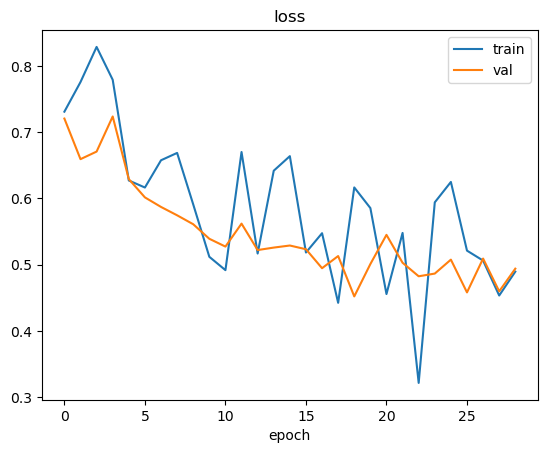

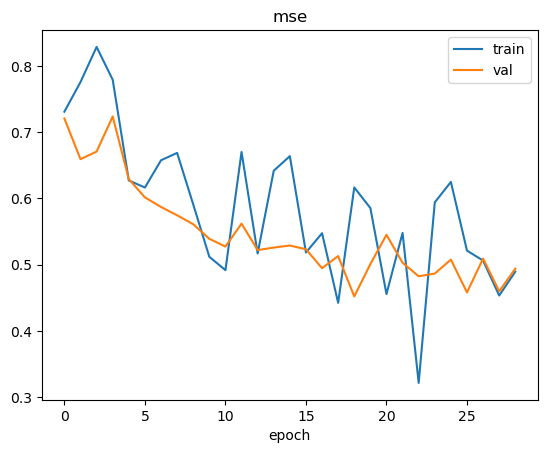

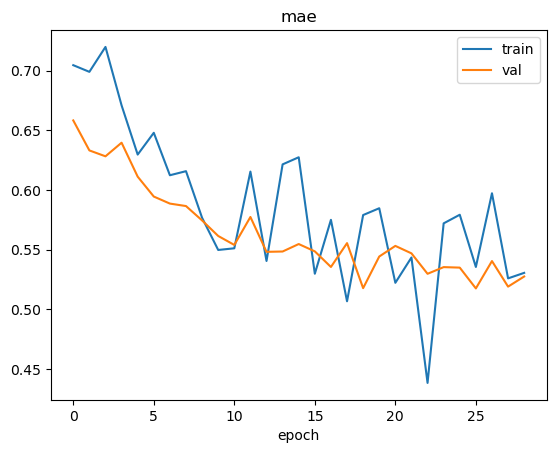

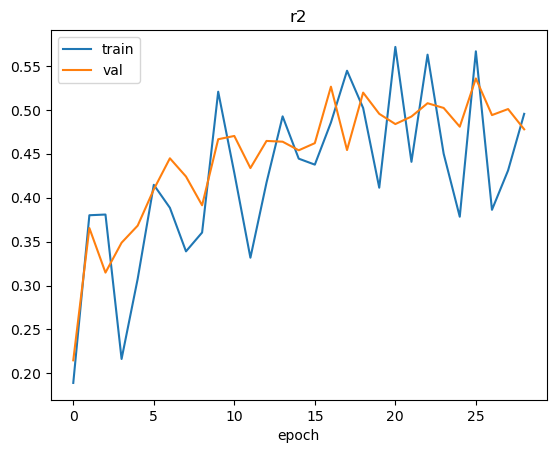

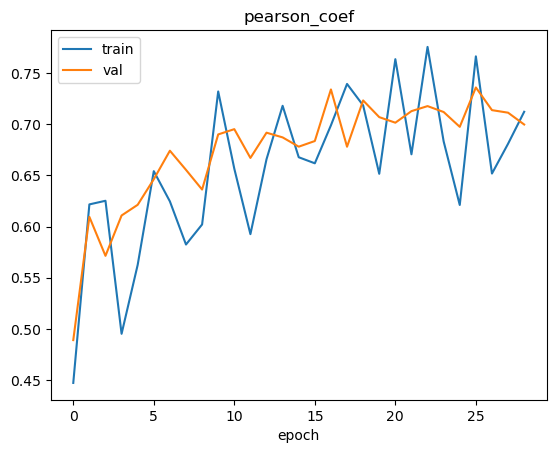

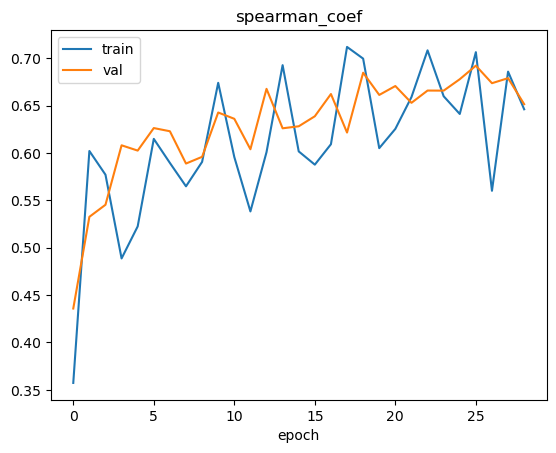

In [ ]:
for name, vals in logger.metrics.items():
    if not name.startswith("train/"):
        continue
    plt.title(name[6:])
    plt.plot(vals, label="train")
    plt.plot(logger.metrics[name.replace("train/", "val/")], label="val")
    plt.legend()
    plt.xlabel("epoch")
    plt.show()

In [9]:
df = pd.read_csv("https://raw.githubusercontent.com/aspuru-guzik-group/chemical_vae/master/models/zinc_properties/250k_rndm_zinc_drugs_clean_3.csv")
X, y = df["smiles"].values, df[["qed"]].values

scaler = StandardScaler()
y_train = scaler.fit_transform(y)
# y_val = scaler.transform(y_val)
# y_test = scaler.transform(y_test)

try:
    mean_ = scaler.mean_
    std_ = scaler.scale_
except:
    mean_ = 0
    std_ = 1

print(mean_, std_)

[0.72826449] [0.13956479]


In [11]:
data_set = FullyConnectedMolData(
    X, torch.tensor(y, dtype=torch.float32),
)

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

batch_size = 256
num_workers = 4
data_loader = DataLoader(
    data_set, batch_size=batch_size, shuffle=False, num_workers=num_workers,
)

model = MoleculeModel.load_from_checkpoint(checkpoint_path="property_model/epoch=24-step=2500.ckpt")
model = model.to(DEVICE)

# For inference
model.eval()    

model_outputs = []  # List to store outputs

from tqdm.notebook import tqdm
import sys

for batch in tqdm(data_loader):
    batch = batch.to(DEVICE)
    out = model(batch)
    print(out[0].shape)
    sys.stdout.flush()
    model_outputs.extend(out[0].flatten().tolist())


model_outputs = np.array(model_outputs) * std_ + mean_
print(len(model_outputs))


/tmp/ipykernel_3681502/3380730969.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)
/data/yulai/anaconda3/envs/mol/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/data/yulai/anaconda3/envs/mol/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


  0%|          | 0/975 [00:00<?, ?it/s]

torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([256, 1])
torch.Size([2

0.4938794106099351


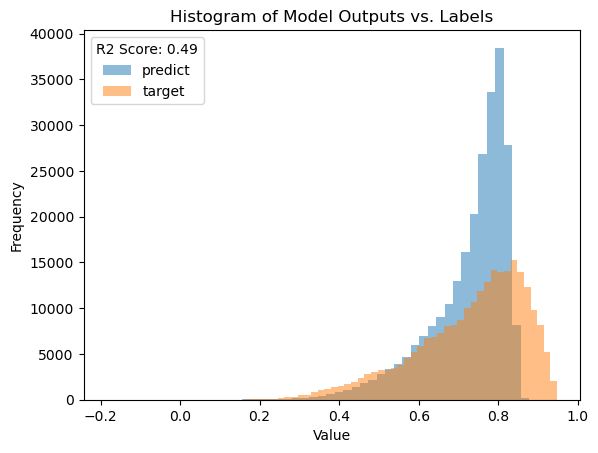

: 

In [12]:
from sklearn.metrics import r2_score

r2 = r2_score(y, model_outputs)
print(r2)

# Plotting histogram of model outputs

plt.hist(model_outputs, bins=50, alpha=0.5, label='predict')
plt.hist(y, bins=50, alpha=0.5, label='target')

plt.title('Histogram of Model Outputs vs. Labels')
plt.xlabel('Value')
plt.ylabel('Frequency')
# Display R2 score in the legend or title if needed
plt.legend(title=f'R2 Score: {r2:.2f}')
plt.show()